**Hint**: For plotting a 3D decision boundry for PCA: https://stackoverflow.com/questions/36232334/plotting-3d-decision-boundary-from-linear-svm

In [1]:
# Perform PCA, classify w/ log regression+ovr, figure decision boundaries

import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from numpy import mean
from numpy import std
from numpy.random import randn
from numpy.random import seed
from numpy import cov
from scipy.stats import pearsonr 
from matplotlib import pyplot
from matplotlib.colors import ListedColormap
import sympy as sympy
import numpy as np
from scipy import *
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Math, Latex
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
X, y = make_blobs(n_samples = 7000,
                  n_features = 11,
                  centers = 4,
                  cluster_std = 1.5,
                  center_box = (-10.0, 10.0))

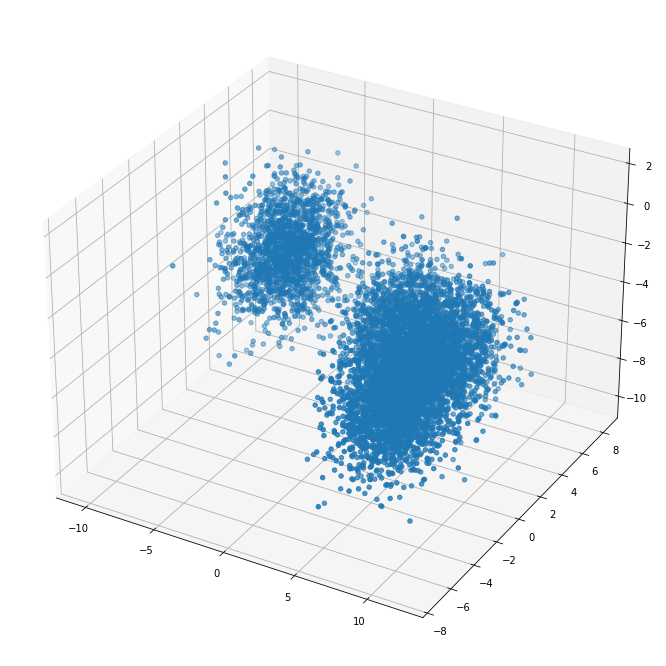

In [3]:
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection ='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
plt.show()

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

In [5]:
# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
print (X_train.shape)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

(4900, 11)


<ipython-input-6-c5d831fa0e40>:2: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sum_EVal = sum(EVal)


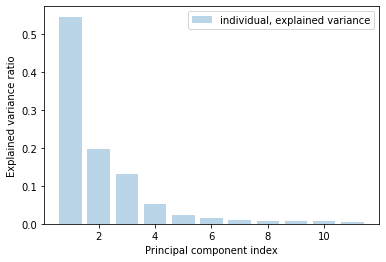

In [6]:
# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Plot explained variances
plt.bar(range(1,12), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [7]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [8]:
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(w)
#the above code is equivalent to that one (using reshape)
#w = np.hstack((eigen_pairs[0][1].reshape(13,1), eigen_pairs[1][1].reshape(13,1)))
#print(w)

[[ 0.37610962 -0.08745253]
 [-0.2127886   0.41238806]
 [-0.26991887 -0.15663752]
 [ 0.30870745  0.40971627]
 [-0.37502959  0.09600107]
 [ 0.10459012  0.29322696]
 [ 0.38991616 -0.02943907]
 [ 0.35065631  0.18698803]
 [ 0.35211644 -0.13945537]
 [ 0.26909962 -0.46238527]
 [ 0.14874387  0.51537174]]


In [9]:
# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)
print (X_train_std.shape, w.shape)

(4900, 11) (11, 2)


In [10]:
# Display LaTeX if you want (but nobody wants that)
display(Math(r'X^*=XW'))

<IPython.core.display.Math object>

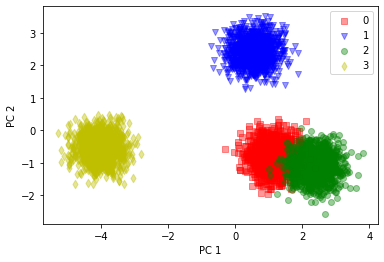

In [11]:
# Visualize the data
colors = ['r', 'b', 'g','y']
markers = ['s', 'v', 'o','d']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper right')
plt.show()

In [12]:
# Set up PCA and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit and transform training data, given on PCA reduction to k(=2) principle components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# solves task, given 3 classes (as from y_train) 
lr.fit(X_train_pca, y_train) 

LogisticRegression(multi_class='ovr', solver='liblinear')

In [13]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # Does not work....always....Setup marker generator and color map: FIXED!
    markers = ('s', 'v', 'o','d') 
    colors = ('r', 'b', 'g','y')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Z is the prediction of the class, given point in plane
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Z=f(xx1,yy1), plot classes in plane using color map but opaque
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot data points, given labels
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

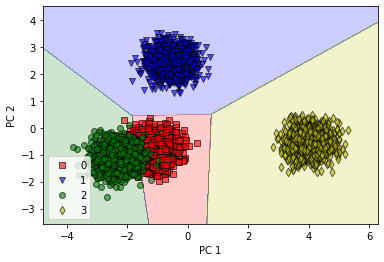

In [14]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

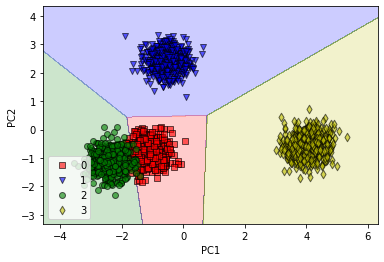

In [15]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()

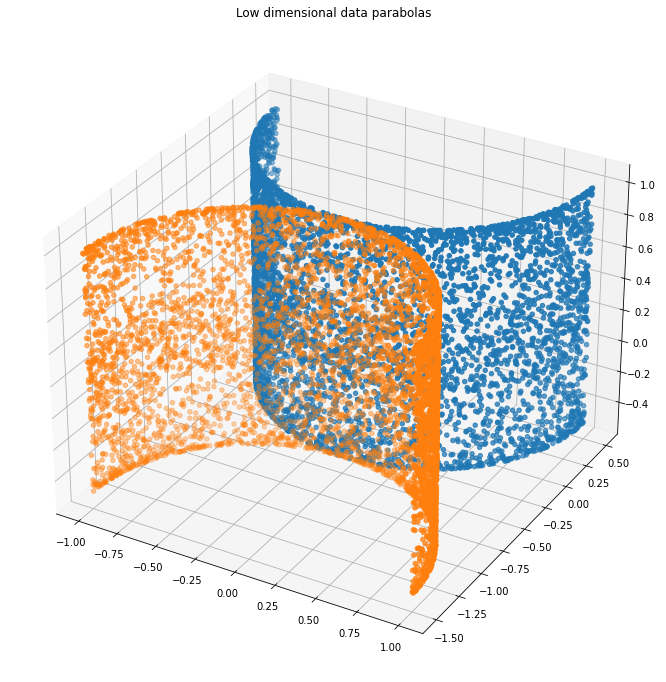

In [16]:
X, y = make_moons(n_samples = 10000)
X = np.column_stack((X, np.random.choice(X[:,1], (len(X),1))))
idx = y == 1
X[idx, 0] = X[idx, 0]-1
X[~idx, 1] = X[~idx, 1]-1.5


fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(X[idx, 0], X[idx, 1], X[idx, 2])
ax.scatter3D(X[~idx, 0], X[~idx, 1], X[~idx, 2])
plt.title("Low dimensional data parabolas")
plt.show()


In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
print (X_train.shape)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]


(7000, 3)


<ipython-input-17-499b0ad8989a>:20: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  sum_EVal = sum(EVal)


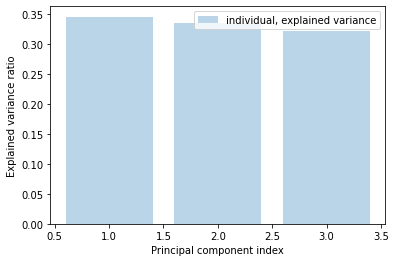

In [18]:

# Plot explained variances
plt.bar(range(1,4), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()


[[ 0.30134409  0.87836419]
 [ 0.62654772 -0.47573087]
 [ 0.71876957  0.04643802]]
(7000, 3) (3, 2)


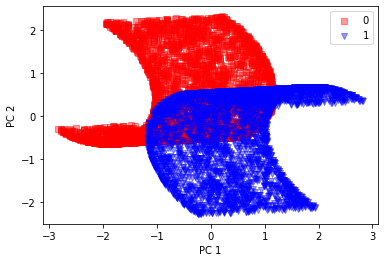

In [27]:

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# Construct matrix w
# stacking, reshaping, adding dim of arrays

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(w)
#the above code is equivalent to that one (using reshape)
#w = np.hstack((eigen_pairs[0][1].reshape(13,1), eigen_pairs[1][1].reshape(13,1)))
#print(w)

# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)
print (X_train_std.shape, w.shape)

# Visualize the data
colors = ['r', 'b']
markers = ['s', 'v']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='upper right')
plt.show()



In [20]:

# Set up PCA and logistic regression model
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', solver='liblinear')

# Fit and transform training data, given on PCA reduction to k(=2) principle components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# solves task, given 3 classes (as from y_train) 
lr.fit(X_train_pca, y_train) 

LogisticRegression(multi_class='ovr', solver='liblinear')

In [21]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # Does not work....always....Setup marker generator and color map: FIXED!
    markers = ('s', 'v', 'o','d') 
    colors = ('r', 'b', 'g','y')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Z is the prediction of the class, given point in plane
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # Z=f(xx1,yy1), plot classes in plane using color map but opaque
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Plot data points, given labels
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

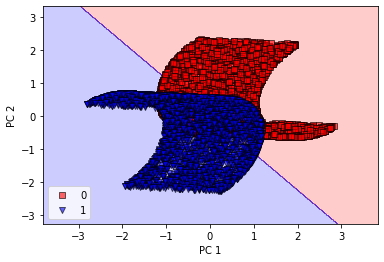

In [22]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

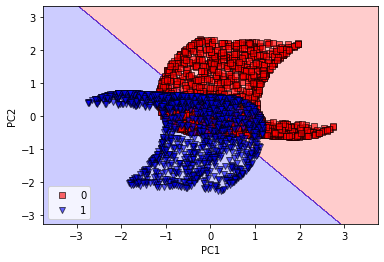

In [23]:
# plot decision regions for test set
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')
plt.show()